In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from typing import Generator, Callable

# Подготовка данных

## Опреределние используемых функций

In [2]:
def load_file(path) -> pd.DataFrame:
    """Загружает данные из exel файла, удаляет незаполненные значения, формирует колонку временной метки"""
    
    df = pd.read_excel(path, header=0)
    df['DateTime']= pd.to_datetime(df['Date'].astype(str)+' '+ df['Time'].astype(str))
    df = df.drop(['Date', 'Time'], axis=1)
    df.replace('-',np.NaN, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    return df

def replace_outliers(df: pd.DataFrame, chunk_size: int, threshold: float) -> pd.DataFrame:
    filtered_data = df.copy()

    # Итерируемся по столбцам DataFrame
    for column in df.columns:
        # Пропускаем столбец с датой и временем
        if column == df.index.name or column == 'Расход нафты ККР на установку'or column == 'DateTime':
            continue

        # Разделяем столбец на блоки размером chunk_size
        chunks = [df[column].iloc[i:i + chunk_size].copy() for i in range(0, len(df), chunk_size)]
        
        # Вычисляем среднее значение для каждого блока
        averages = [chunk.mean() for chunk in chunks]
        averages = pd.Series(averages)

        # Вычисляем границы значения на основе порога threshold
        lower_bound = np.percentile(averages, threshold)
        upper_bound = np.percentile(averages, 100 - threshold)

        # Если все значения средних являются пустыми, пропускаем столбец
        if averages.isnull().all():
            continue

        # Заменяем значения в блоках, которые выходят за границы
        for i, avg in averages.items():
            if avg < lower_bound or avg > upper_bound:
                start_index = i * chunk_size
                end_index = (i + 1) * chunk_size
                filtered_data.loc[start_index:end_index, column] = np.nan
    
    # Применяем линейную интерполяцию и заполняем пропущенные значения
    for column in filtered_data.columns:
        if column != df.index.name:
            filtered_data[column] = filtered_data[column].interpolate(method='linear')
            filtered_data[column].fillna(method='ffill', inplace=True)
            filtered_data[column].fillna(method='bfill', inplace=True)

    return filtered_data


def plot_timedelta_distr(df: pd.DataFrame, name=None) -> None:
    """Рисует гистограмму распределения временными промежутками между соседними измерениями"""
    
    delta_arr = []
    for i in range(1, len(df)):
        delta_arr.append(df.iloc[i, -1] - df.iloc[i-1, -1])
    print(Counter(delta_arr), '\n')
    hist_arr = [i.total_seconds()/60 for i in delta_arr]
    plt.hist(hist_arr,)
    plt.xlabel("Величина промежутка между измерениями, мин")
    plt.ylabel("Количество промежутков")
    if name is not None:
        plt.title(name)
    plt.show()


def construct_XY(df_X: pd.DataFrame, df_Y: pd.DataFrame, diff1: pd.Timedelta, diff2: pd.Timedelta) -> Generator[np.ndarray, np.ndarray, pd.Timestamp]:
    """Формирует генератор точек X и Y, каждому Y соответствует несколько X во временном промежутке"""
    
    num = 0
    Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
    X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
    for i in range(len(df_X)):
        timeX = df_X.iloc[i, -1]
        timeY = df_Y.iloc[num, -1]
        if timeX > timeY:
            # if timeX - timeY < diff2:
            #      tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
            #      X = np.vstack((X, tmp_X))
            yield X, Y, timeY
            num += 1            
            if num >= len(df_Y):
                break
            
            X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
            Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
            continue
  
        if (timeY - timeX > diff2) or (timeY - timeX < diff1):
            continue
        tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
        X = np.vstack((X, tmp_X))


def plot_num_distr(gen, name=None) -> None:
    """Рисует гистограмму распрделения количества точек X на одну точку Y"""
    
    shapes = []
    i = 0
    for x, y, _ in gen:
        i += 1
        shapes.append(len(x))
    print(f"Количество точек {i} \n")
    print(f'Распределение количества примеров \n {Counter(shapes)} \n')
    plt.hist(shapes)
    plt.xlabel("Количетсво точек X на одно лабораторное измерение")
    plt.ylabel("Количество записей")
    if name is not None:
        plt.title(name)
    plt.plot()

## Загрузка файлов

In [3]:
df_Y1 = load_file('Исходные данные/Лабораторные анализы Давление насыщенных паров в продукте, зимний период.xlsx')
df_Y2 = load_file('Исходные данные/Лабораторные анализы Конец кипения легкого бензина.xlsx')
df_Y3 = load_file('Исходные данные/Лабораторные анализы Содержание олефинов в продукте.xlsx')

df_X1 = replace_outliers(load_file('Исходные данные/Процессные данные Давление насыщенных паров в продукте, зимний период.xlsx'),50,10)
df_X2 = replace_outliers(load_file('Исходные данные/Процессные данные Конец кипения легкого бензина.xlsx'),50,10)
df_X3 = replace_outliers(load_file('Исходные данные/Процессные данные Содержание олефинов в продукте.xlsx'),50,10)

C:\Users\PC\AppData\Local\Temp\ipykernel_10248\3959022539.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data[column].fillna(method='ffill', inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_10248\3959022539.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data[column].fillna(method='bfill', inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_10248\3959022539.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data[column].fillna(method='ffill', inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_10248\3959022539.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data[column].f

In [4]:
df_Y1

Давление насыщенных паров, зимний период, кПа            DateTime
0                                             49.8 2022-01-01 11:21:00
1                                             52.3 2022-01-02 10:50:00
2                                             50.7 2022-01-03 10:24:48
3                                             52.6 2022-01-04 11:12:49
4                                             54.7 2022-01-05 10:23:28
..                                             ...                 ...
291                                           59.3 2023-12-05 11:30:47
292                                           57.4 2023-12-07 10:21:11
307                                           56.9 2024-01-30 11:27:17
308                                           60.7 2024-02-01 11:17:48
309                                           57.4 2024-02-06 11:46:26

[134 rows x 2 columns]

In [5]:
df_X1

Расход бензина ККР на установку  Расход нафты ККР на установку  \
0                                95.63                          32.56   
1                                95.98                          32.80   
2                                95.60                          32.76   
3                                95.72                          32.76   
4                                95.53                          32.80   
...                                ...                            ...   
12884                           103.80                           0.00   
12885                           103.66                           0.00   
12886                           103.14                           0.00   
12887                           103.68                           0.00   
12888                           101.99                           0.00   

       Расход бензина на рециркуляцию от Е-1205  \
0                                          0.00   
1                                          0.00   
2                                          0.00   
3                                          0.00   
4                                          0.00   
...                                         ...   
12884                                      3.93   
12885                                      1.28   
12886                                      0.20   
12887                                      1.28   
12888                                      0.00   

       Температура бензина ККР на установку  Давление в емкости V-1101  \
0                                     32.23                       1.21   
1                                     32.23                       1.20   
2                                     32.23                       1.20   
3                                     32.23                       1.20   
4                                     32.23                       1.20   
...                                     ...                        ...   
12884                                 35.60                       1.20   
12885                                 35.85                       1.20   
12886                                 35.53                       1.20   
12887                                 35.54                       1.20   
12888                                 35.35                       1.20   

       Расход сырья после Р-1101  Показатель соотношения водород к углероду  \
0                         146.96                                       5.31   
1                         147.27                                       5.30   
2                         146.05                                       5.34   
3                         146.19                                       5.34   
4                         145.76                                       5.32   
...                          ...                                        ...   
12884                     143.04                                       5.53   
12885                     142.90                                       5.52   
12886                     143.09                                       5.53   
12887                     143.59                                       5.50   
12888                     144.18                                       5.48   

       Расход водорода на смешение перед Е-1101  \
0                                        781.16   
1                                        779.64   
2                                        780.48   
3                                        780.53   
4                                        776.46   
...                                         ...   
12884                                    789.95   
12885                                    789.97   
12886                                    789.97   
12887                                    790.03   
12888                                    790.01   

       Температура сырья перед Е-1101  Давление сырья перед Е-1101

В загруженных файлах заменены пропуски, которые в таблице обозначены "-" на NaN значения, эти строки отброшены.

## Анализ данных

In [6]:
pd.set_option('display.max_columns', None)
min_var = 0.01

In [7]:
def dataframe_info(df):
    df = df.drop(columns=['DateTime'])
    variance = df.var()
    std = df.std()
    means = df.mean()
    medians = df.median()
    mins = df.min()
    maxes = df.max()
    df_info = pd.DataFrame([variance, std, means, medians, mins, maxes], index=['variance', 'standart deviation', 'mean', 'median', 'min', 'max'])
    return df_info

def drop_low_variance(df, df_info, min_var):
    df2 = df[df.columns[:-1]].T
    m1 = df_info.loc['variance'] < min_var
    drop_cols =  df2.loc[m1].T.columns
    df.drop(columns=list(drop_cols), inplace=True)

Простоим таблицу основных статистических величин для каждой переменной в каждом датасете, отбросим те величины, дисперсия которых меньше чем min_var, постоим графики плотности распределения каждой из сотавшихся величин

## X1

In [8]:
df_info_X1 = dataframe_info(df_X1)
df_info_X1

Расход бензина ККР на установку  \
variance                                 410.328892   
standart deviation                        20.256577   
mean                                      99.342104   
median                                   104.810000   
min                                        0.000000   
max                                      131.880000   

                    Расход нафты ККР на установку  \
variance                                10.533270   
standart deviation                       3.245500   
mean                                     0.368503   
median                                   0.000000   
min                                      0.000000   
max                                     38.650000   

                    Расход бензина на рециркуляцию от Е-1205  \
variance                                           35.457256   
standart deviation                                  5.954600   
mean                                                2.562297   
median                                              0.000000   
min                                                 0.000000   
max                                               103.200000   

                    Температура бензина ККР на установку  \
variance                                        7.606121   
standart deviation                              2.757920   
mean                                           35.103369   
median                                         35.550000   
min                                            19.450000   
max                                            39.960000   

                    Давление в емкости V-1101  Расход сырья после Р-1101  \
variance                             0.000012                 195.894357   
standart deviation                   0.003525                  13.996227   
mean                                 1.200334                 143.442845   
median                               1.200000                 143.980000   
min                                  1.060000                 119.970000   
max                                  1.310000                 180.200000   

                    Показатель соотношения водород к углероду  \
variance                                             0.759088   
standart deviation                                   0.871257   
mean                                                 5.631111   
median                                               5.840000   
min                                                  0.000000   
max                                                  7.310000   

                    Расход водорода на смешение перед Е-1101  \
variance                                        24000.592481   
standart deviation                                154.921246   
mean                                              817.047760   
median                                            849.750000   
min                                                 0.000000   
max                                              1124.950000   

                    Температура сырья перед Е-1101  \
variance                                  7.348344   
standart deviation                        2.710783   
mean                                     37.416239   
median                                   37.880000   
min                                      25.440000   
max                                      44.360000   

                    Давление сырья перед Е-1101  \
variance                               0.003512   
standart deviation                     0.059259   
mean                                  29.065524   
median                                29.070000   
min                                   27.560000   
max                                   29.350000   

                    Температура сырья перед Е-1102  \
variance                                  8.550754   
standart deviation                        2.924167   
mean                                    108.642717   
m

In [9]:
drop_low_variance(df_X1, df_info_X1, min_var)

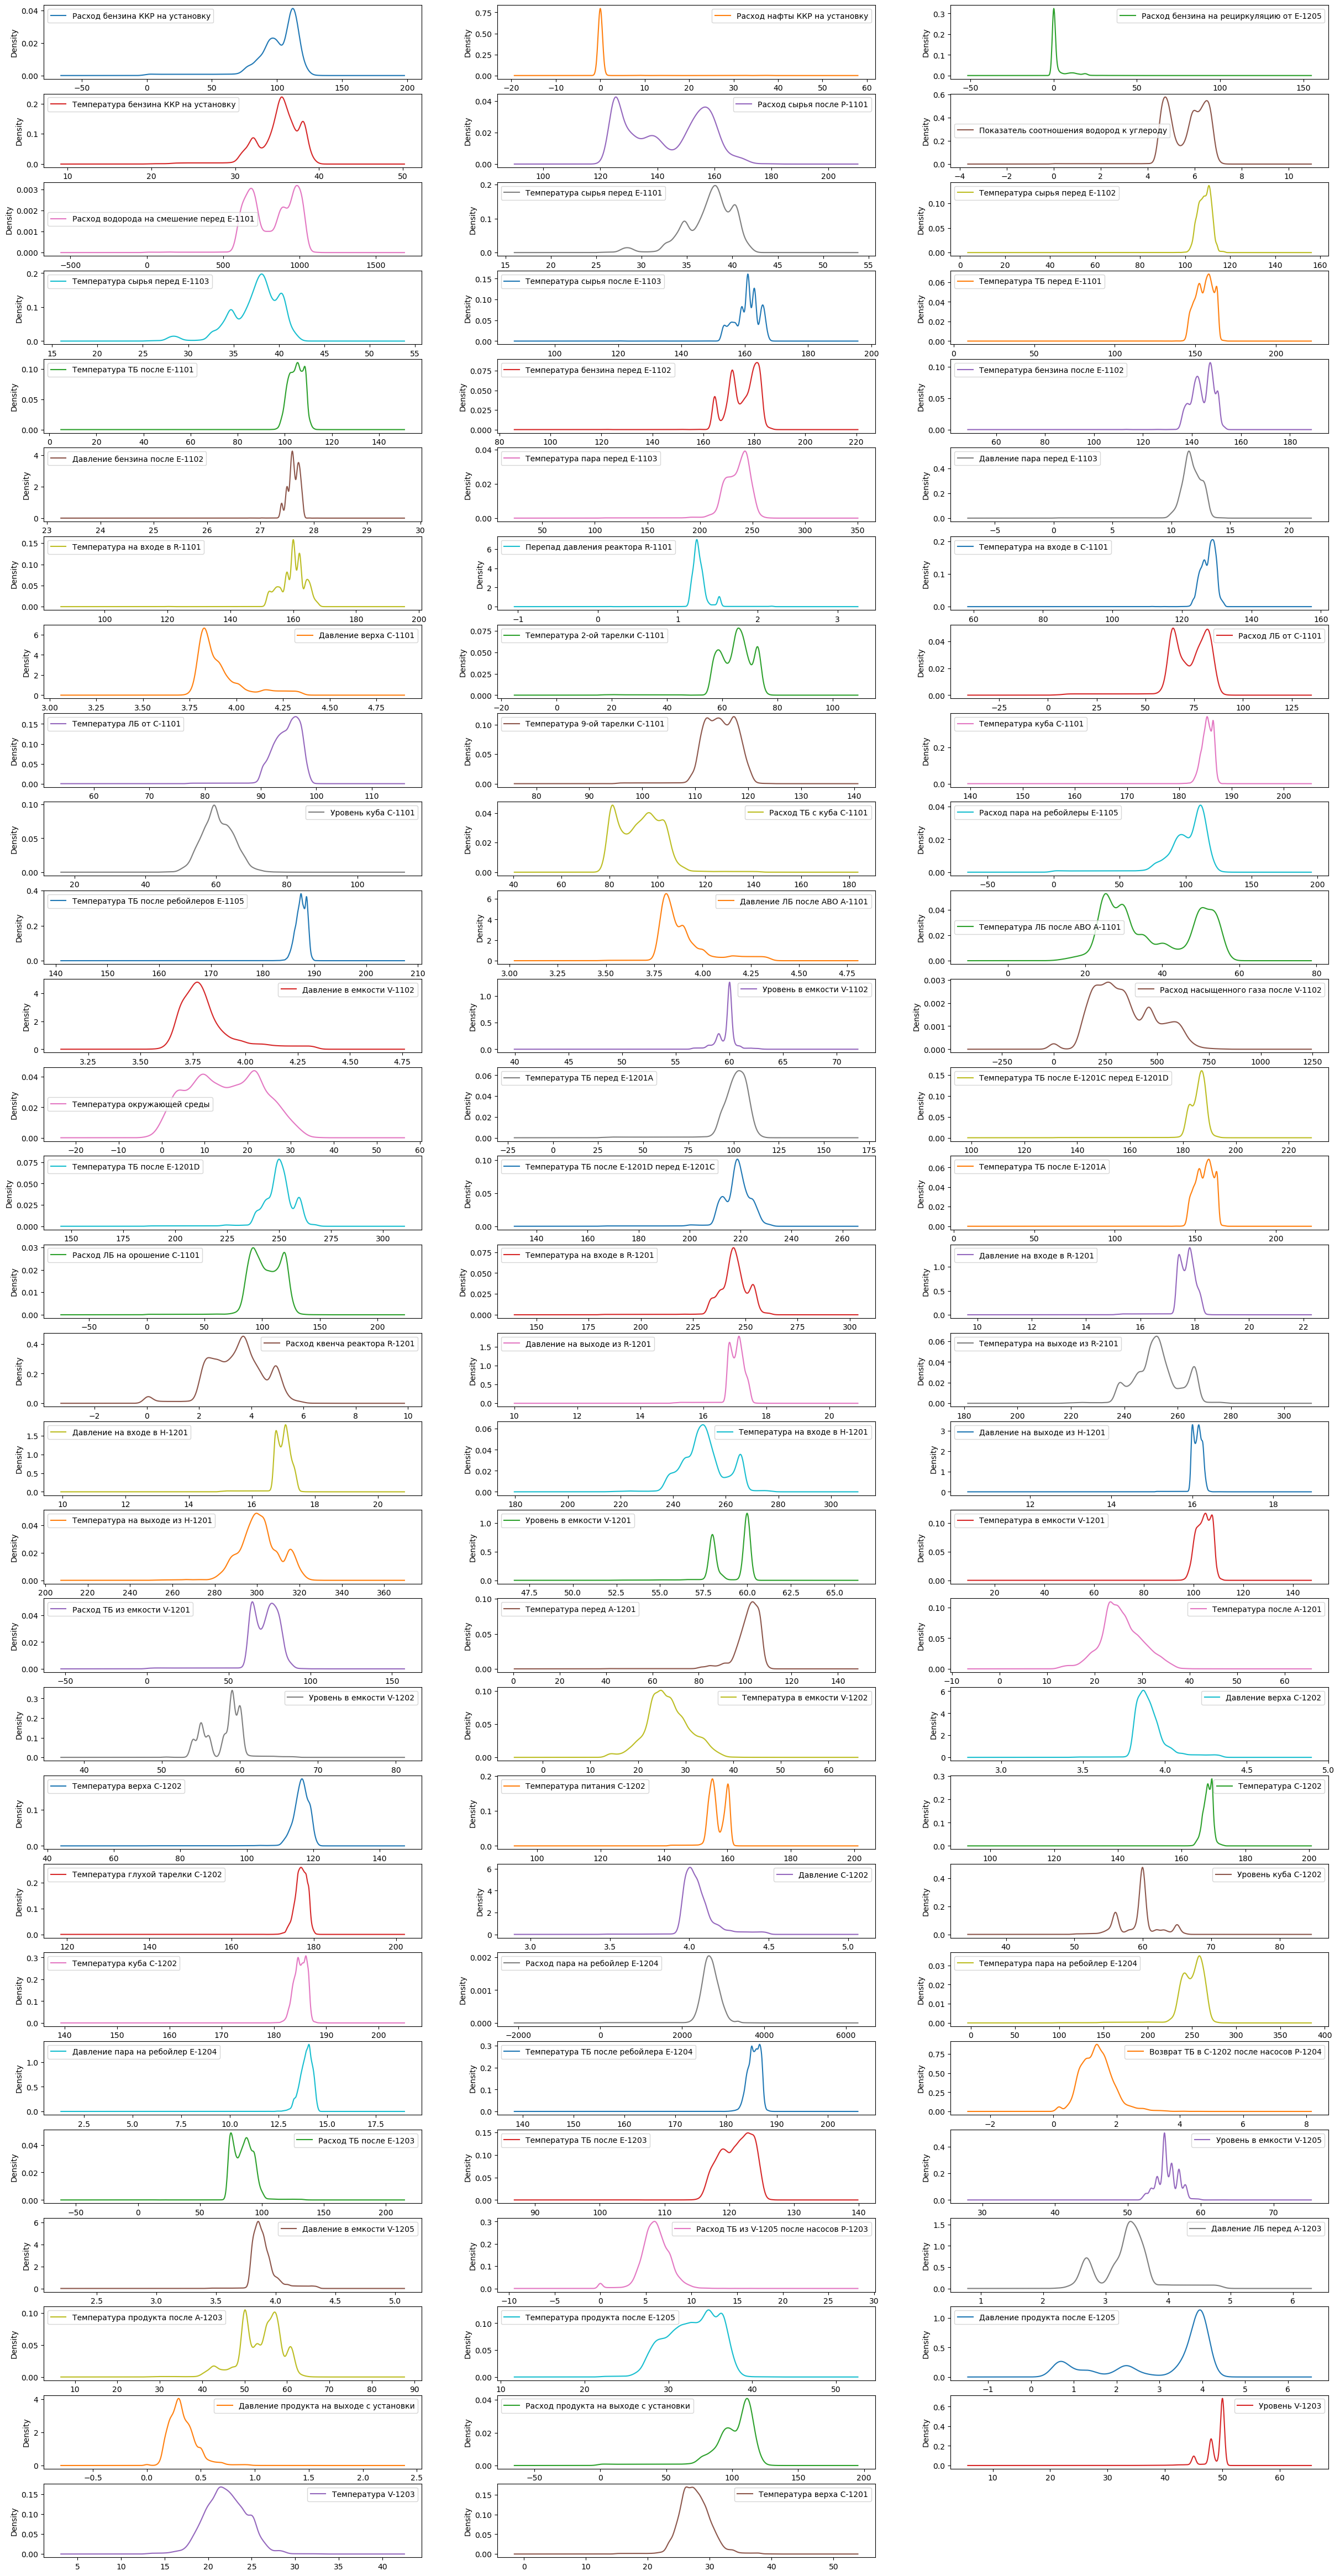

In [10]:
df_X1[df_X1.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

## X2

In [11]:
df_info_X2 = dataframe_info(df_X2)
df_info_X2

Расход бензина ККР на установку  \
variance                                 410.328892   
standart deviation                        20.256577   
mean                                      99.342104   
median                                   104.810000   
min                                        0.000000   
max                                      131.880000   

                    Расход нафты ККР на установку  \
variance                                10.533270   
standart deviation                       3.245500   
mean                                     0.368503   
median                                   0.000000   
min                                      0.000000   
max                                     38.650000   

                    Расход бензина на рециркуляцию от Е-1205  \
variance                                           35.457256   
standart deviation                                  5.954600   
mean                                                2.562297   
median                                              0.000000   
min                                                 0.000000   
max                                               103.200000   

                    Температура бензина ККР на установку  \
variance                                        7.606121   
standart deviation                              2.757920   
mean                                           35.103369   
median                                         35.550000   
min                                            19.450000   
max                                            39.960000   

                    Давление в емкости V-1101  Расход сырья после Р-1101  \
variance                             0.000012                 195.894357   
standart deviation                   0.003525                  13.996227   
mean                                 1.200334                 143.442845   
median                               1.200000                 143.980000   
min                                  1.060000                 119.970000   
max                                  1.310000                 180.200000   

                    Показатель соотношения водород к углероду  \
variance                                             0.759088   
standart deviation                                   0.871257   
mean                                                 5.631111   
median                                               5.840000   
min                                                  0.000000   
max                                                  7.310000   

                    Расход водорода на смешение перед Е-1101  \
variance                                        24000.592481   
standart deviation                                154.921246   
mean                                              817.047760   
median                                            849.750000   
min                                                 0.000000   
max                                              1124.950000   

                    Температура сырья перед Е-1101  \
variance                                  7.348344   
standart deviation                        2.710783   
mean                                     37.416239   
median                                   37.880000   
min                                      25.440000   
max                                      44.360000   

                    Давление сырья перед Е-1101  \
variance                               0.003512   
standart deviation                     0.059259   
mean                                  29.065524   
median                                29.070000   
min                                   27.560000   
max                                   29.350000   

                    Температура сырья после Е-1103  \
variance                                 15.477935   
standart deviation                        3.934201   
mean                                    160.773203   
m

In [12]:
drop_low_variance(df_X2, df_info_X2, min_var)

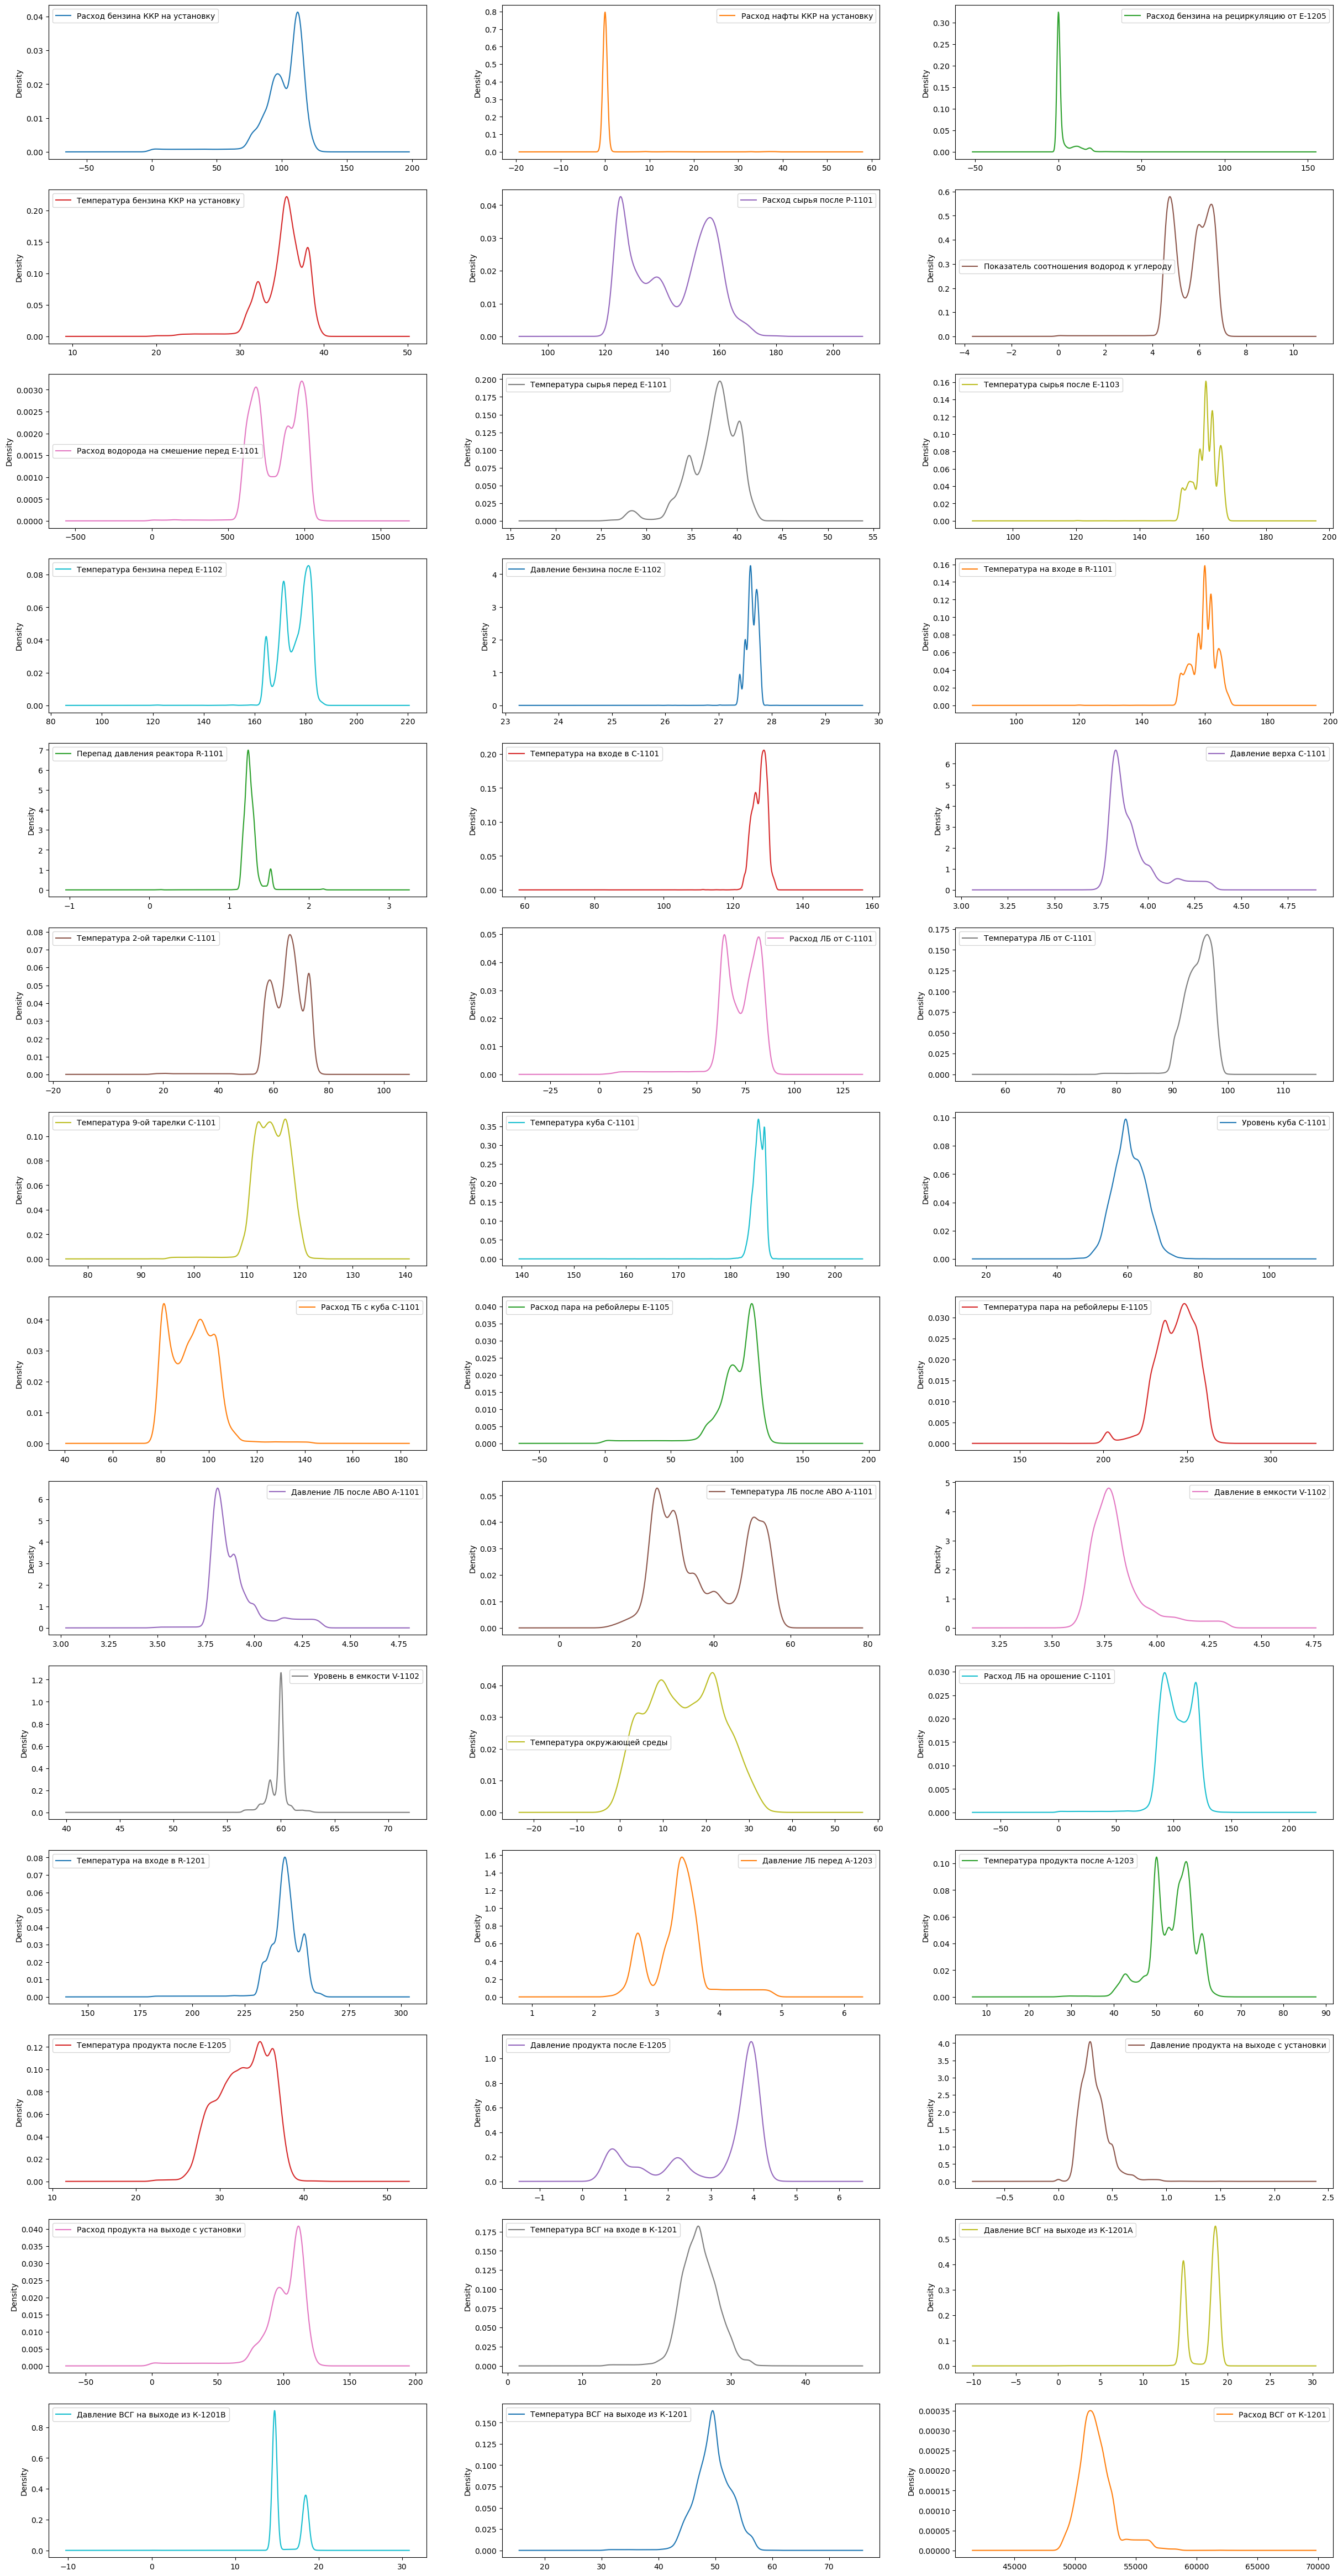

In [13]:
df_X2[df_X2.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

## X3

In [14]:
df_info_X3 = dataframe_info(df_X3)
df_info_X3

4FI3401_DACA_PV/Var/MV/Расход бензина ККР на установку/  \
variance                                                   410.328892         
standart deviation                                          20.256577         
mean                                                        99.342104         
median                                                     104.810000         
min                                                          0.000000         
max                                                        131.880000         

                    4FI3402_DACA_PV/Var/MV/Расход нафты ККР на установку/  \
variance                                                     0.000091       
standart deviation                                           0.009518       
mean                                                         0.003032       
median                                                       0.000000       
min                                                          0.000000       
max                                                          0.160000       

                    4FIC1002_PIDA_PV/Var/MV/Расход бензина на рециркуляцию от Е-1205/  \
variance                                                    35.457256                   
standart deviation                                           5.954600                   
mean                                                         2.562297                   
median                                                       0.000000                   
min                                                          0.000000                   
max                                                        103.200000                   

                    4TI1002_DACA_PV/Var/MV/Температура бензина ККР на установку/  \
variance                                                     7.606121              
standart deviation                                           2.757920              
mean                                                        35.103369              
median                                                      35.550000              
min                                                         19.450000              
max                                                         39.960000              

                    4PIC1035A_PIDA_PV/Var/MV/Давление в емкости V-1101/  \
variance                                                     0.000012     
standart deviation                                           0.003525     
mean                                                         1.200334     
median                                                       1.200000     
min                                                          1.060000     
max                                                          1.310000     

                    4FIC1010_PIDA_PV/Var/MV/Расход сырья после Р-1101/  \
variance                                                   195.894357    
standart deviation                                          13.996227    
mean                                                       143.442845    
median                                                     143.980000    
min                                                        119.970000    
max                                                        180.200000    

                    4FFIC1003_RATIOCTLA_SP/Var/MV/Показатель соотношения водород к углероду/  \
variance                                                     0.759088                          
standart deviation                                           0.871257                          
mean                                                         5.631111                          
median                                                       5.840000                          
min                                                          0.000000                          
max                                                          7.310000                       

In [15]:
drop_low_variance(df_X3, df_info_X3, min_var)

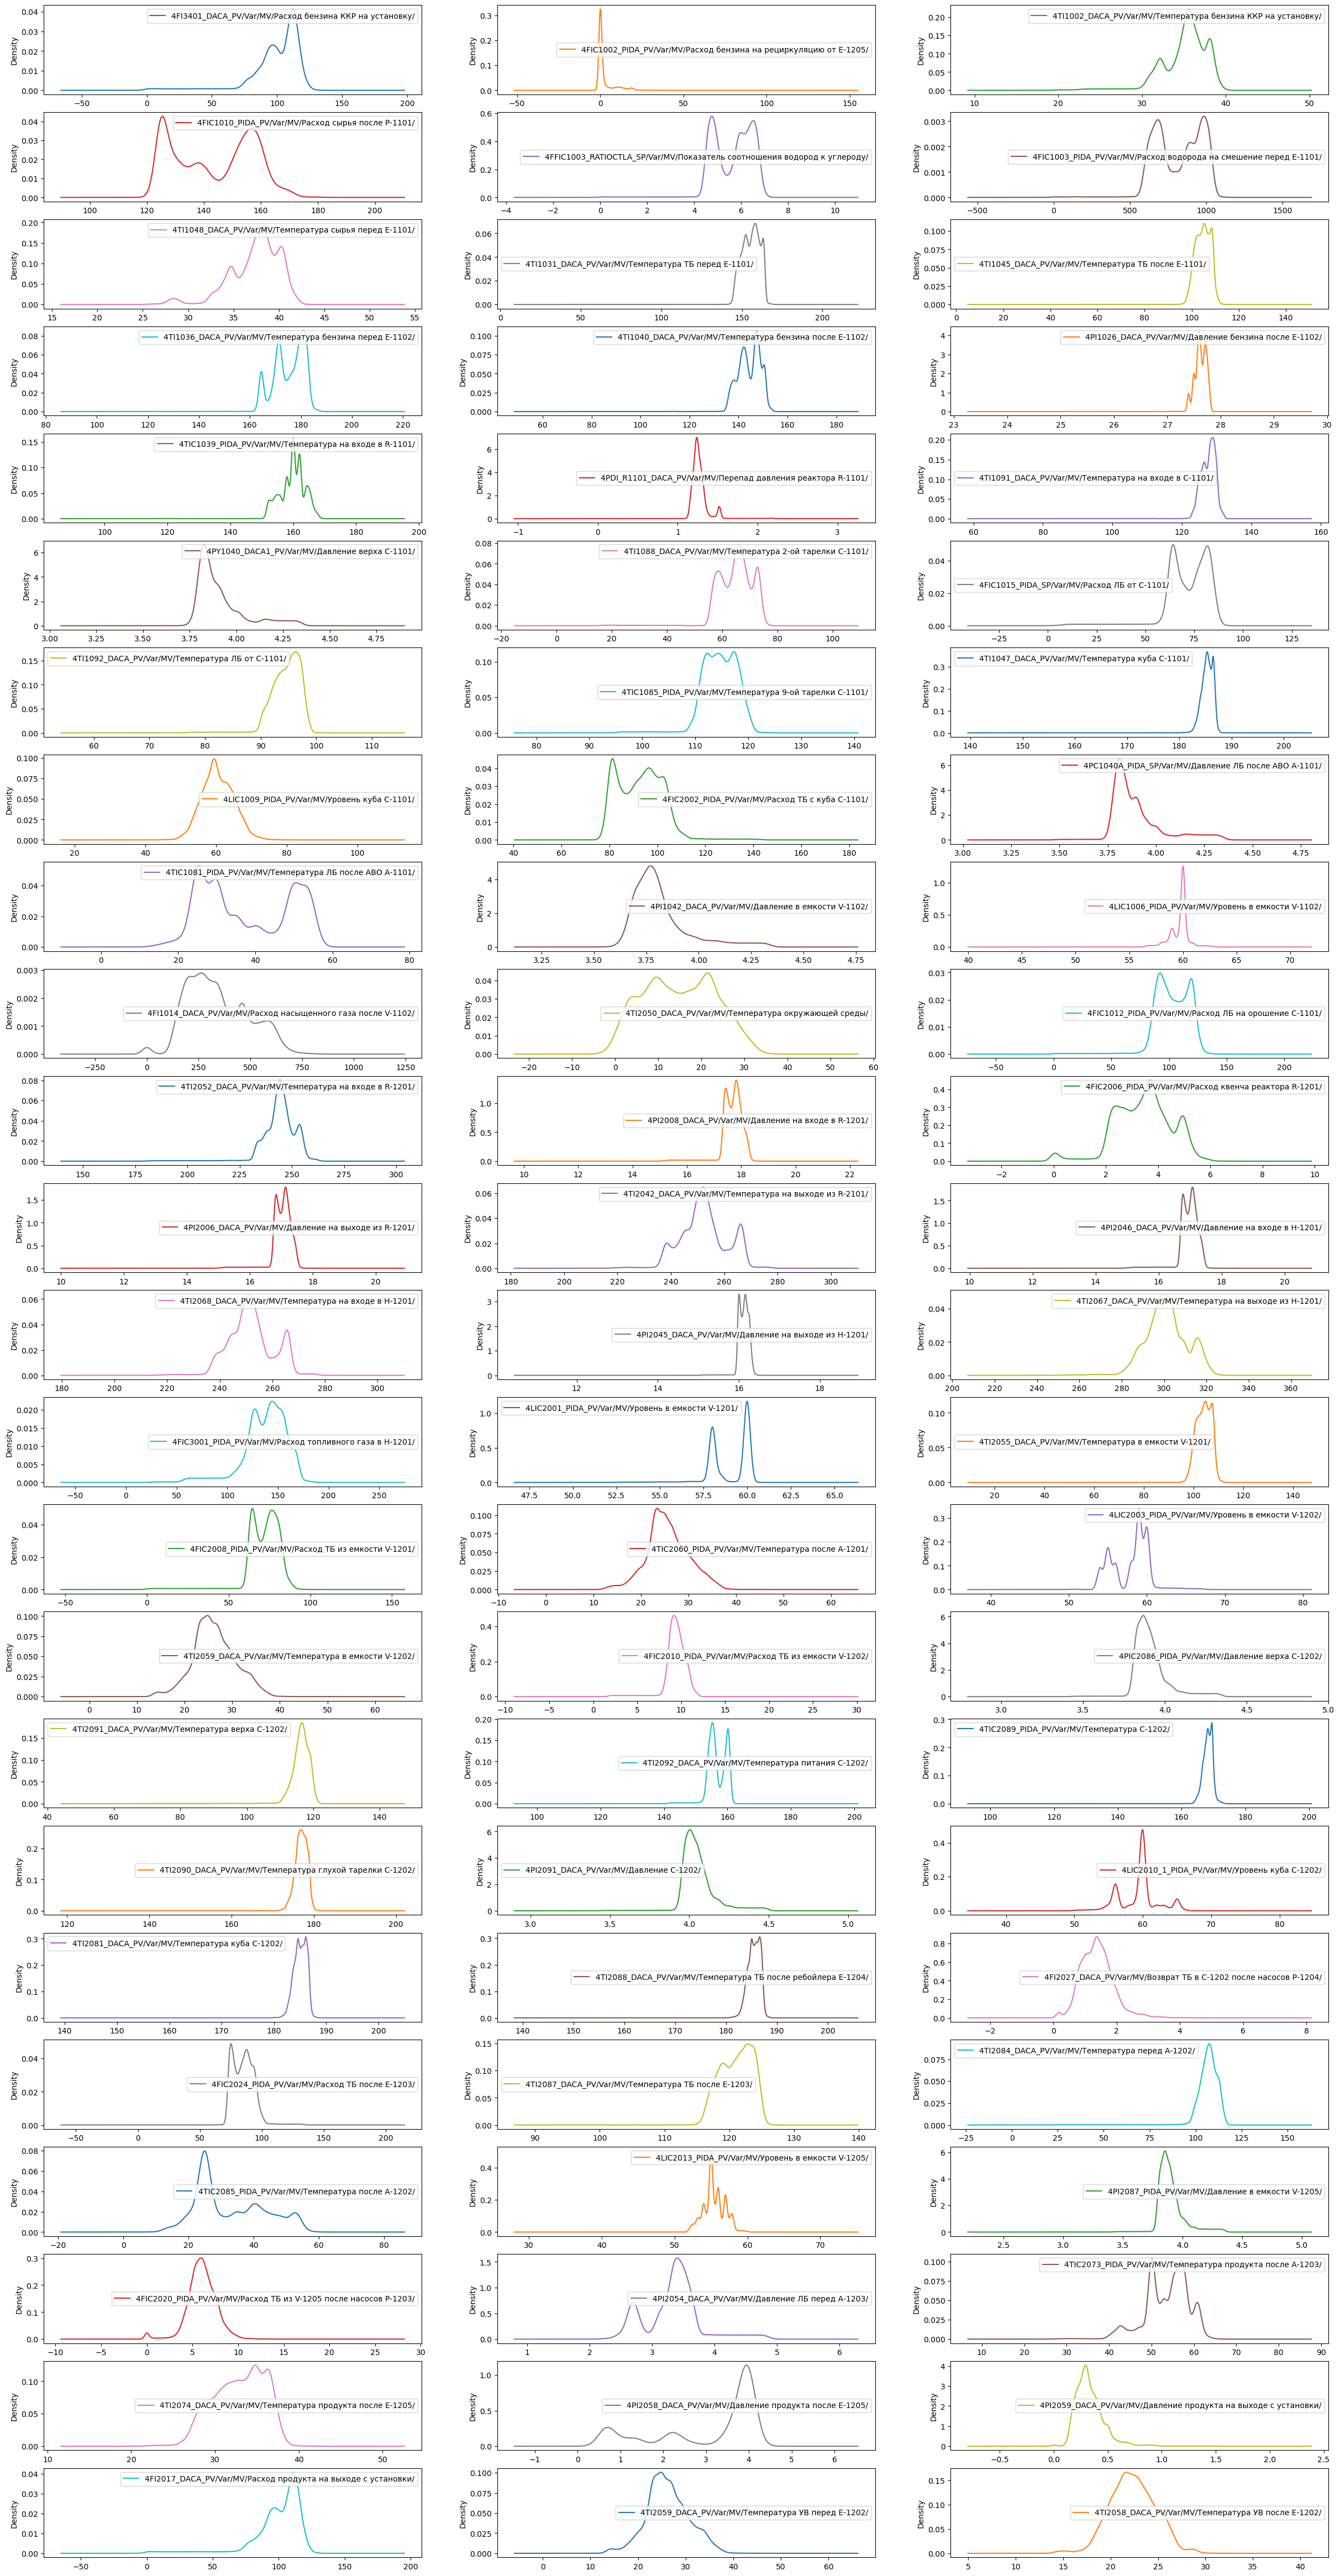

In [16]:
df_X3[df_X3.columns[:-1]].plot(kind='density', subplots = True, layout=(-1,3), figsize=(30, 60), sharex=False)
plt.show()

Посмотрим, какая регулярность измерений процессорных данных. Для этого построим гистограмму распределения временного промежутка (в минутах) между двумя соседними измерениями.
Лабораторные анализы проиводились крайне нерегулярно, для них такая диаграмма не имеет смысла.

Counter({Timedelta('0 days 01:27:55'): 5992, Timedelta('0 days 01:25:00'): 1998, Timedelta('0 days 01:29:20'): 1998, Timedelta('0 days 01:27:50'): 1996, Timedelta('0 days 01:00:00'): 888, Timedelta('0 days 00:11:15'): 4, Timedelta('0 days 00:45:00'): 2, Timedelta('0 days 02:27:50'): 2, Timedelta('0 days 00:34:30'): 2, Timedelta('0 days 00:36:00'): 2, Timedelta('0 days 00:27:55'): 2, Timedelta('0 days 01:11:15'): 2}) 



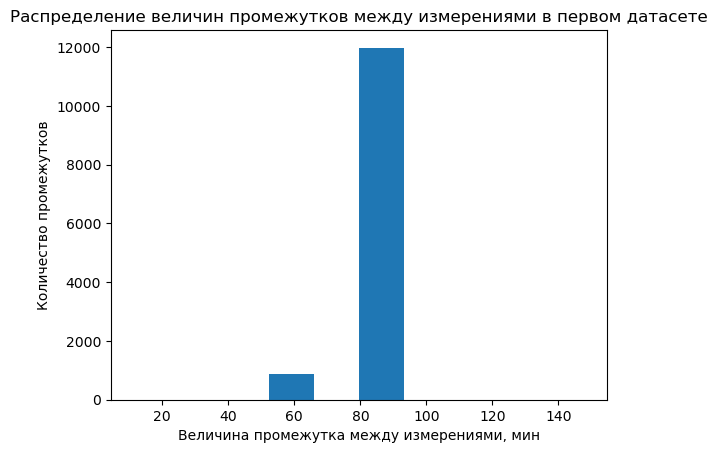

In [17]:
plot_timedelta_distr(df_X1, "Распределение величин промежутков между измерениями в первом датасете")

Как мы видим, даже процессорные измерения были не полностью регулярные, что может сказаться на количестве процессорных значений, соответствующих одному лабораторному анализу

Пройдёмся по нашим процессорным данным и поставим в соответствие лабораторным измерениям те процессорные данные, которые были получены не дальше чем diff времени до лабораторного анализа или diff2 времени после лабораторного анализа

In [18]:
diff1 = pd.to_timedelta('1h')
diff2 = pd.to_timedelta('4h')

Количество точек 134 

Распределение количества примеров 
 Counter({2: 116, 3: 13, 0: 5}) 



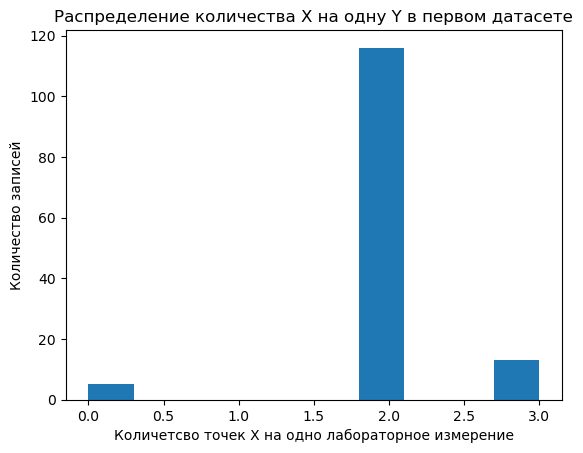

In [19]:
plot_num_distr(construct_XY(df_X1, df_Y1, diff1, diff2), "Распределение количества X на одну Y в первом датасете")

Количество точек 110 

Распределение количества примеров 
 Counter({2: 96, 3: 14}) 



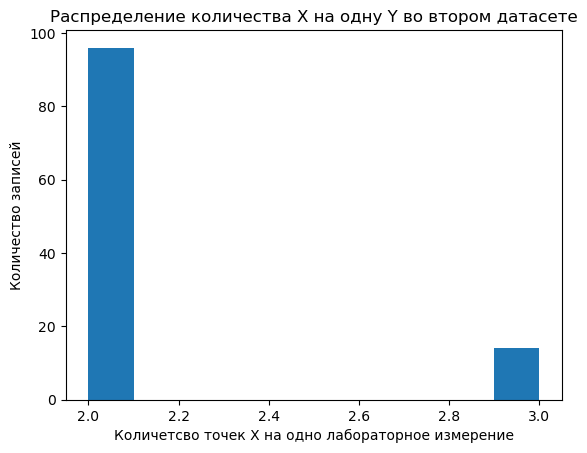

In [20]:
plot_num_distr(construct_XY(df_X2, df_Y2, diff1, diff2), "Распределение количества X на одну Y во втором датасете")

Количество точек 226 

Распределение количества примеров 
 Counter({2: 205, 3: 20, 1: 1}) 



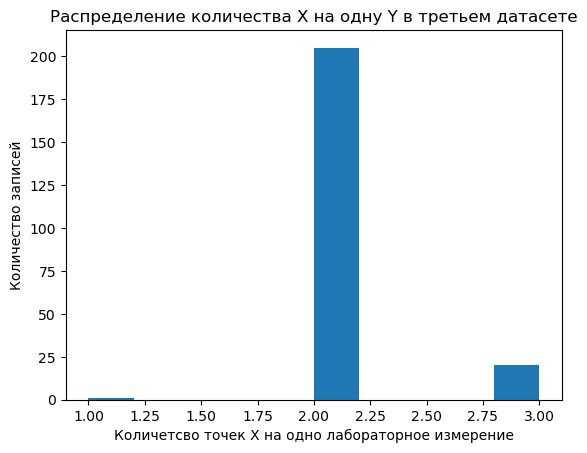

In [21]:
plot_num_distr(construct_XY(df_X3, df_Y3, diff1, diff2), "Распределение количества X на одну Y в третьем датасете")

Как мы видим, при данных временных рамках одному лабораторному анализу может соответствовать от нуля до пяти процессорных данных. Чтобы иметь возможность адекватно обрабатывать данные, необходимо отбросить точки без процессорных данных и свести процессорные данные к единому формату. 
Подобная обработка процессорных данных может быть проделана, используя среднее или экпоенециальное среднее

## Формирование тестовой и обучающей выборки

## Описание функций

Функция формирования тестовой и обучающей выборки в numpy массивов, значения Х в каждой точке агрегируются в вектор. На вход подаётся свежий экземпляр генератора точек X и Y и функция агрегирования

In [22]:
def form_datasets(gen: Generator[tuple, None, None], aggregate_func: Callable[[np.ndarray], np.ndarray]):
    # Собираем все данные из генератора
    all_X = []
    all_Y = []
    all_timestamps = []

    for x, y, timestamp in gen:
        if len(x) > 0:
            all_X.append(aggregate_func(x))
            all_Y.append(y)
            all_timestamps.append(timestamp)

    # Переводим собранные данные в массивы NumPy
    all_X = np.array(all_X, dtype=np.float64)
    all_Y = np.array(all_Y, dtype='object')
    all_timestamps = np.array(all_timestamps, dtype='object').reshape(-1, 1)

    # Добавляем временные метки к Y
    all_Y_with_timestamps = np.hstack((all_Y, all_timestamps))

    return all_X, all_Y_with_timestamps

def form_datasets_periods(gen, agregate_func) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Формирует 2 numpy.ndarray в порядке x_summer_half, y_summer_half, x_winter_half, y_winter_half,
    значения X получены через функцию агрегирования agregate_func."""

    # Получение первой порции данных из генератора для определения размеров массивов
    try:
        x, y, timestamp = next(gen)  
    except StopIteration:
        # Если генератор не возвращает данных, завершаем функцию и возвращаем пустые массивы
        return (np.array([], dtype=np.float64).reshape(0, 0),
                np.array([], dtype=np.float64).reshape(0, 0),
                np.array([], dtype=np.float64).reshape(0, 0),
                np.array([], dtype=np.float64).reshape(0, 0))

    # Инициализируем массивы для записи данных
    x_summer_half = np.array([], dtype=np.float64).reshape(0, x.shape[1])
    x_winter_half = np.array([], dtype=np.float64).reshape(0, x.shape[1])
    y_summer_half = np.array([], dtype='object').reshape(0, len(y) + 1)
    y_winter_half = np.array([], dtype='object').reshape(0, len(y) + 1)

    # Обрабатываем оставшиеся данные
    for x, y, timestamp in gen:
        if len(x) == 0:
            continue
        
        x_agg = agregate_func(x)

        # Распределение данных по выборкам в зависимости от месяца
        if 4 <= timestamp.month <= 9:
            y_summer_half = np.vstack((y_summer_half, np.append(y, timestamp)))
            x_summer_half = np.vstack((x_summer_half, x_agg))
        else:
            y_winter_half = np.vstack((y_winter_half, np.append(y, timestamp)))
            x_winter_half = np.vstack((x_winter_half, x_agg))

    return x_summer_half, y_summer_half, x_winter_half, y_winter_half

def form_datasets_cat(gen: Generator[tuple, None, None], aggregate_func: Callable[[np.ndarray], np.ndarray]):
    # Собираем все данные из генератора
    all_X = []
    all_Y = []
    all_timestamps = []
    all_X_season = []  # Создаем список для сезонного столбца

    for x, y, timestamp in gen:
        if len(x) > 0:
            all_X.append(aggregate_func(x))
            all_Y.append(y)
            all_timestamps.append(timestamp)
            # Добавляем значение в список сезонного столбца
            all_X_season.append(1 if 4 <= timestamp.month <= 9 else 0)

    # Переводим собранные данные в массивы NumPy
    all_X = np.array(all_X, dtype=np.float64)
    all_Y = np.array(all_Y, dtype='object')
    all_timestamps = np.array(all_timestamps, dtype='object').reshape(-1, 1)
    all_X_season = np.array(all_X_season, dtype=np.float64).reshape(-1, 1)  # Преобразуем список в массив NumPy

    # Добавляем временные метки к Y
    all_Y_with_timestamps = np.hstack((all_Y, all_timestamps))

    # Добавляем сезонный столбец к all_X
    all_X = np.hstack((all_X, all_X_season))

    return all_X, all_Y_with_timestamps

Функция агрегирования, обобщающая использование арифметического среднего, последнего значения и взвешенного экпоненциального среднего

In [23]:
def exp_average(arr: np.ndarray, alpha=0) -> np.ndarray:
    """Функция взвешенного среднего для агрегирования значений X. При alpha = 0 результат - арифметическое среднее, 
    при alpha = 1 результат - последнее значение, при alpha = (0, 1) результат - экспоненциальное взвешенное среднее"""

    arr = arr[::-1]
    out_arr = np.zeros(arr.shape[1])
    coeff_sum = 0
    for pow, row in enumerate(arr):
        coeff = (1-alpha)**pow
        out_arr = out_arr + row*coeff
        coeff_sum += coeff
    
    out_arr = out_arr/coeff_sum
    return out_arr

Сохранение данных в .npz архив

In [24]:
def save_datasets(gen1, gen2, gen3, gen2_cat, gen3_cat,df_X1,df_X2,df_X3,func, func_name) -> None:
    """Генерирует и сохраняет датасеты с определённой функцией агрегирования func в .npz архив под именем Data_func_name.npz"""
    column_names_1 = df_X1.columns[:-1].tolist()
    column_names_2_cat = df_X2.columns[:-1].tolist()
    column_names_2_cat += ['Время года(1 - лето,0 - зима)']
    column_names_3_cat = df_X3.columns[:-1].tolist()
    column_names_3_cat += ['Время года(1 - лето,0 - зима)']
    column_names_2 = df_X2.columns[:-1].tolist()
    column_names_3 = df_X3.columns[:-1].tolist()
    all_X_1, all_Y_1 = form_datasets(gen1, func)
    x_summer_half_2, y_summer_half_2, x_winter_half_2, y_winter_half_2 = form_datasets_periods(gen2, func)
    x_summer_half_3, y_summer_half_3, x_winter_half_3, y_winter_half_3 = form_datasets_periods(gen3, func)
    all_X_2, all_Y_2 = form_datasets_cat(gen2_cat,func)
    all_X_3, all_Y_3 = form_datasets_cat(gen3_cat,func)
    
    np.savez_compressed(
        "Data_" + func_name +".npz", 
        all_X_1 = all_X_1, all_Y_1=all_Y_1, 
        x_summer_half_2=x_summer_half_2, y_summer_half_2=y_summer_half_2, x_winter_half_2=x_winter_half_2, y_winter_half_2=y_winter_half_2,
        x_summer_half_3=x_summer_half_3, y_summer_half_3=y_summer_half_3, x_winter_half_3=x_winter_half_3, y_winter_half_3=y_winter_half_3,
        all_X_2 = all_X_2, all_Y_2 = all_Y_2,
        all_X_3 = all_X_3, all_Y_3 = all_Y_3,
        column_names_1 = column_names_1, column_names_2_cat = column_names_2_cat, column_names_3_cat = column_names_3_cat,
        column_names_2 = column_names_2, column_names_3 = column_names_3
    )                 

## Сохранение размеченных данных

Сохраним архивы с 3 вариантами агрегирования (арифметическое среднее, последнее измерение, взвешенное экспоненциальное среднее. 

В каждом архиве находятся по 4 массива для 3 виртуальных анализаторов. Номер ВА - последняя цифра в названии массива (1 - Давление насыщенных паров в продукте, зимний период, 2 - Конец кипения легкого бензина, 3 - Содержание олефинов в продукте). 

Каждый массив построен по следующему принципу Y[N], X[N, C], где N - номер точки, C - номер процессорного значения.

In [25]:
save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    df_X1,
    df_X2,
    df_X3,
    lambda x: exp_average(x, alpha=0),
    "Average_Misha"
)

save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    df_X1,
    df_X2,
    df_X3,
    lambda x: exp_average(x, alpha=1),
    "First_Misha"
)

save_datasets(
    construct_XY(df_X1, df_Y1, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    construct_XY(df_X2, df_Y2, diff1, diff2),
    construct_XY(df_X3, df_Y3, diff1, diff2),
    df_X1,
    df_X2,
    df_X3,
    lambda x: exp_average(x, alpha=0.5),
    "Exponential_Average_Misha"
)

In [26]:
df_X1.to_csv('raw_X1.csv')
df_X2.to_csv('raw_X2.csv')
df_X3.to_csv('raw_X3.csv')

df_Y1.to_csv('raw_Y1.csv')
df_Y2.to_csv('raw_Y2.csv')
df_Y3.to_csv('raw_Y3.csv')